This notebook is meant for identifying and fitting features in 1D spectrum as well applying a final wavelength axis correction based on skyline comparison. Much of the plotting and fitting described in these tasks can be performed by splot in IRAF, and I would actually implore the user to work with splot if possible due to its more robust line fitting algorithms and more interactive plotting features. The plotting and fitting methods presented here can function on their own as alternatives to IRAF's splot, but they are perhaps best used as a supplement to IRAF so that one may have two different sets of fits to compare.

Fitting and plotting aside, the pixel-wavelength conversion task included here is particularly useful for determining where 2D features in pixel space may be found in 1D wavelength-calibrated spectra (or vice versa), and the wavelength correction task included at the end is an essential part of the overal spectroscopic analysis. The line determinations here may also be compiled and passed to the check_redshift notebook to determine the redshift of a given spectrum.

As always, any changes or improvements are welcome, and feel free to modify the code to your own needs!

-Armaan Goyal

In [26]:
#import packages and set plotting style
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from scipy import optimize as op
from scipy import signal as sig
from scipy.ndimage.filters import gaussian_filter1d
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clipped_stats
from scipy.interpolate import interp1d

def data_from_text(filename):
    data = np.genfromtxt(filename, usecols = (0, 1))
    wav, flux = np.split(data, 2, axis = 1)
    flux = np.reshape(flux, len(flux))
    wav = np.reshape(wav, len(wav))
    return wav, flux

Below is an extremely simple plotting function for basic visualization of spectra and getting a first estimate as to where potential features may lie. We see in the example below a clear emission line at ~7270 angstroms.

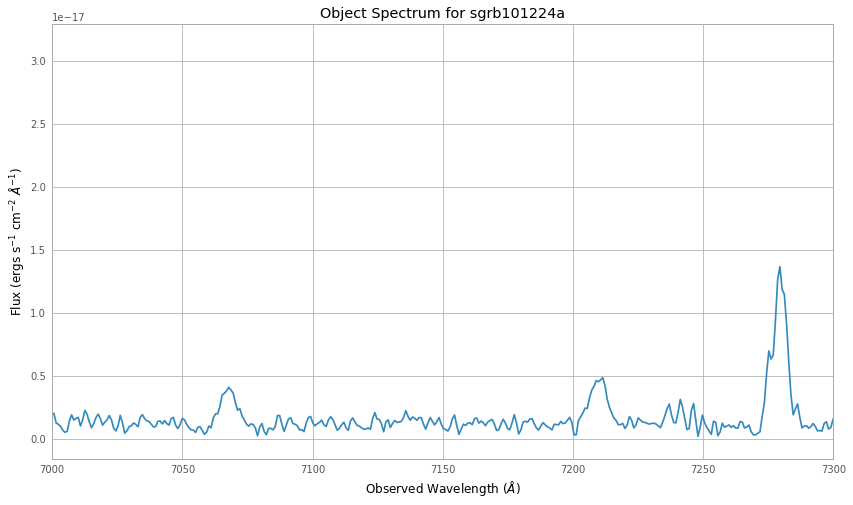

In [22]:
def plot_data(filename, **kwargs):
    fig = plt.figure(figsize=(14,8)) 
    wav, flux = data_from_text(filename)
    x_lim = kwargs.get("x_lim", None)
    y_lim = kwargs.get("y_lim", None)
    plt.plot(wav, flux)
    plt.ylabel("Flux (ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)")
    plt.xlabel("Observed Wavelength ($\AA$)")
    if x_lim:
        plt.xlim(x_lim[0], x_lim[1])
    if y_lim:
        plt.ylim(y_lim[0], y_lim[1])
    plt.title("Object Spectrum for sgrb101224a")
    plt.show()

plot_data("sgrb101224a_ext", x_lim = (7000, 7300))

This module is meant to assist in locating features in 1D spectra by determining the corresponding wavelength values for their pixel locations in the 2D data. The module can also convert wavelength values back into pixel space if one wishes to check the veracity of a spike in 1D data. Options are included to print approximate conversion values as well as to plot the conversion relation.

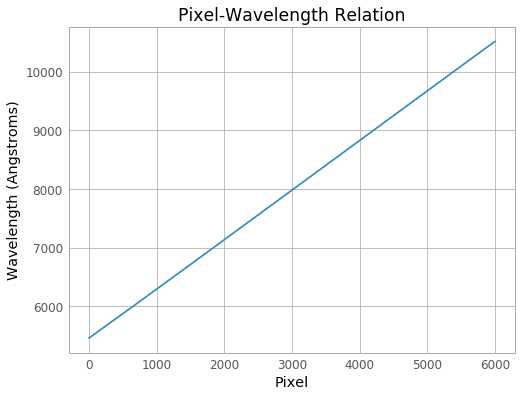

Conversion is 0.8427 angstroms per pixel or 1.1866 pixels per angstrom
A wavelength of 5713.30 angstroms corresponds to a pixel value of 305.25.


array([305.24841852])

In [27]:
def pix_wav_conv(file, values, value_type, slope = True, plot = True, flip = False):
    '''
    Attempts to determine line profile of emission features by smoothing and fitting to either a Gaussian or Lorentzian.
    
    Parameters:
    -----------
    file(str): name of input text file
    values (list of floats): list of values to convert (must be a list even if single value)
    value_type (str): "pix" if pixel values are input, "wav" for wavelengths
    slope (bool): toggle to print value of pixel-wavelength conversion
    plot (bool): toggle to plot pixel-wavelength relation
    flip (bool): use if inputting raw MODS red channel data (not processed by modsCCDRed, axis is flipped initially)
    
    Returns:
    --------
    Pixel values converted to wavelengths (or vice versa). Options for plotting pixel-wavelength relation and printing its average value.
    
    '''
    data = np.genfromtxt(file, usecols = (0, 1))
    pix = np.arange(np.shape(data)[0])
    wav = data[:, 0]
    if flip:
        wav = np.flip(wav)
    if plot:
        #fig = plt.figure(figsize=(6,3))
        plt.title("Pixel-Wavelength Relation")
        plt.ylabel("Wavelength (Angstroms)")
        plt.xlabel('Pixel')
        plt.plot(pix, wav)
        plt.show()
    if slope:
        m = (wav[-1] - wav[0])/(pix[-1] - pix[0])
        print("Conversion is %.4f angstroms per pixel or %.4f pixels per angstrom"%(m, (1/m)))
    if value_type == "wav":
        interp = interp1d(wav, pix)
        conv = interp(values)
        for i in range(len(values)):
            print("A wavelength of %.2f angstroms corresponds to a pixel value of %.2f."%(values[i], conv[i]))
    if value_type == "pix":
        conv = np.interp(values, pix, wav)
        for i in range(len(values)):
            print("A pixel value of %.2f corresponds to a wavelength of %.2f angstroms."%(values[i], conv[i]))
    return conv

        
pix_wav_conv("130822a_flux_red", [5713.3], "wav", slope = True, flip = False)

The following is code for semi-automatic line fitting, and includes routines for both Lorentizan and Gaussian line modeling as well as for Gaussian filter and Savitsky-Golay smoothing to make the fitting process easier. This task is the main method for determining the locations of features in the data, but it requires a fair amount of manual input. It is best to use the previous task to get an estimate of the plotting window and line location, and then performing multiple passes with different fitting windows to best capture the endpoints of the line.

In [10]:
#define profiles for fitting

def gaussian(x, a, mu, sigma):
    return a*np.exp(-1*((x-mu)**2)/(2*sigma**2))

def lorentzian(x, a, x0, gamma):
    return a/(1 + ((x - x0)/(gamma/2))**2)

def line_fitting(filename, fit_type, fit_window, g, x_lim, y_lim, **kwargs):
    '''
    Attempts to determine line profile of emission features by smoothing and fitting to either a Gaussian or Lorentzian.
    
    Parameters:
    -----------
    filename (str): name of input file
    fit_type (str): type of profile to use for fitting, input "g" for Gaussian or "l" for Lorentzian
    fit_window (tuple of ints): endpoints of feature to be fit, should determined conservatively (limit strictly to line profile)
    g (tuple of floats and ints): tuple of initial guesses for line profile parameters in form of (height, center, half-width)
    x_lim (tuple of ints): x-window of plot
    y_lim (tuple of ints): y-window of plot
    
    Optional Parameters:
    --------------------
    smooth (str): type of smoothing (if desired), "g" for Gaussian and "sg" for Savitzky-Golay
    poly_order (int): Use only if smooth = "sg". Order of SG smoothing polynomial.
    window (tuple of ints): Use only if smooth = "sg". Window size for SG smoothing, must be odd and greater than poly_order.
    sigma (float): Use only if smooth = "g". Std. dev. of Gaussian smoothing filter.
    
    Returns:
    --------
    Plots data and smoothed data with best-fit profile. Prints and returns tuple of model parameters.
    
    '''
    fig = plt.figure(figsize=(14,8)) 
    data = np.genfromtxt(filename, usecols = (0, 1))
    wav, flux = np.split(data, 2, axis = 1)
    flux = np.reshape(flux, len(flux))
    wav = np.reshape(wav, len(wav))
    sm = kwargs.get("smooth", None)
    sg_window = kwargs.get("window", 15)
    sg_order = kwargs.get("poly_order", 3)
    g_sigma = kwargs.get("sigma", 2)
    plt.plot(wav, flux, label = "Flux-Calibrated Spectrum")
    if sm == "sg":
        flux = sig.savgol_filter(flux, sg_window, sg_order)
        plt.plot(wav, flux, ls = "--", label = "SG Smoothed Data for %s"%filename)
        print("Savitzky-Golay filter applied with window size %d and polynomial order %d"%(sg_window, sg_order))
    if sm == "g":
        flux = gaussian_filter1d(flux, g_sigma)
        plt.plot(wav, flux, ls = "--", label = "Gaussian Smoothed Data for %s"%filename)
        print("Gaussian Filter applied with std. dev. %.1f"%(g_sigma))
    lim = (wav > fit_window[0]) & (wav < fit_window[1])
    (wav_sub, flux_sub) = (wav[lim], flux[lim])
    if fit_type == "g":
        popt, pcov = op.curve_fit(gaussian, wav_sub, flux_sub, p0=[g[0], g[1], g[2]])
        plt.plot(wav_sub, gaussian(wav_sub, popt[0], popt[1], popt[2]), label = "Gaussian Fit for Trace")
        print("Line fit to Gaussian with amplitude %1.20f, center at %.2f angstroms and std. dev. %.2f angstroms"%(popt[0], popt[1], popt[2]))
    if fit_type == "l":
        popt, pcov = op.curve_fit(lorentzian, wav_sub, flux_sub, p0=[g[0], g[1], g[2]])
        plt.plot(wav_sub, lorentzian(wav_sub, popt[0], popt[1], popt[2]), label = "Lorentzian Fit for Trace")
        print("Line fit to Lorentzian with amplitude %1.20f, center at %.2f angstroms, and gamma of %.2f angstroms"%(popt[0], popt[1], popt[2]))
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Angstroms)')
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])
    plt.title("Line Profile Fitting for Feature at %.2f Angstroms"%popt[1])
    plt.legend()
    plt.show()
    return popt

Gaussian Filter applied with std. dev. 1.0
Line fit to Lorentzian with amplitude 0.00000000000000001288, center at 7279.47 angstroms, and gamma of 6.50 angstroms


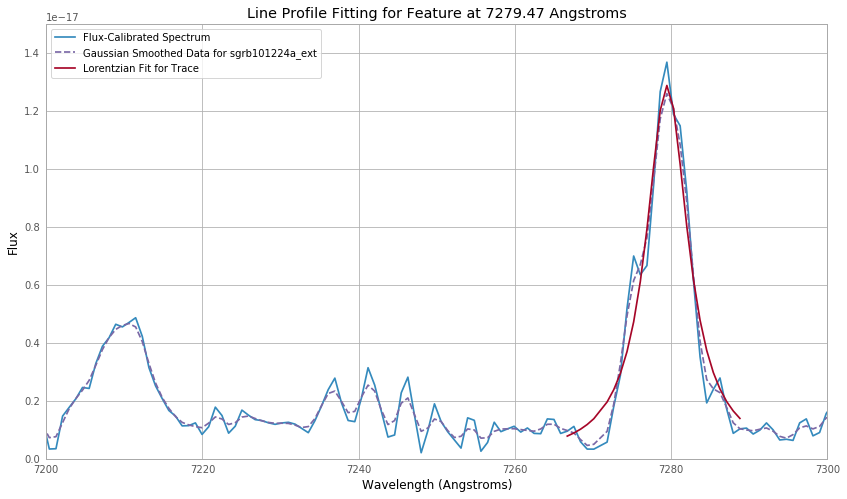

array([1.28773639e-17, 7.27946988e+03, 6.49935697e+00])

In [21]:
filename = "sgrb101224a_ext"

#fitting parameters
fit_type = "l" #l for lorentzian, g for gaussian
initial_guess = (1.5*10**(-18), 7270, 10) #formatted as (height, center, width)
fit_window = (7266, 7289) #determining these bounds will probably require some guess-and-check, should be the edges of the line profile

#plotting
x_window = (7200, 7300)
y_window = (0, 1.5*(10**-17))

#smoothing
smooth = "g"

#if Gaussian smoothing
sigma = 1

#if SG smoothing
#sg_window = 
#poly_order = 

line_fitting(filename, fit_type, fit_window, initial_guess, x_window, y_window, smooth = "g", sigma = sigma)

This final task is used to provide the final corrections to the wavelength axis of a given 1D spectrum. Lists of common optical skylines are included below, and one can use splot or the fitting code above to determine the corresponding locations of these lines in the observed data. These wavelength values can then be passed in with the calibration list to determine either a constant shift in or rescaling of the wavelength axis, and object/error spectra can be passed in to apply the adjustment and save the output as a text file.

In [23]:
def spec_adjust(sky_obs, sky_real, adj_type, **kwargs):  
    '''
    Provides final adjustments for wavelength axis of 1D spectra.
    Uses differences between observed skylines and their lab wavelenghts to either shift or rescale the horizontal axis.
    
    Parameters:
    -----------
    sky_obs (list of float): list of observed skylines in non-background-subtracted data
    sky_real (list of float): list of lab wavelengths corresponding to sky_obs (in the same order)
    adj_type (str): type of adjustment desired, "shift" for constant shift at all wavelengths, "scale" for axial rescaling (reccommended)

    Optional Parameters:
    --------------------
    spec (str): name of spectrum to be corrected, output will have same filename with "_shiftadj" or "_scaleadj" appended depending on type of adjustment.
    err(str): name of error spectrum to be corrected, naming conventions same as above
    
    Returns:
    --------
    Prints magnitude of shift or rescaling needed. If input spectra are provided, will adjust data and save output in current directory.
    
    '''
    spec = kwargs.get("spec", None)
    err = kwargs.get("err", None)
    obs_arr = np.array(sky_obs)
    real_arr = np.array(sky_real)
    if adj_type == "shift":
        adj = np.mean(real_arr - obs_arr)
        print(real_arr - obs_arr)
        print("A shift of %.2f angstroms is needed based on skyline alignment"%adj)
    if adj_type == "scale":
        adj = np.mean(real_arr/obs_arr)
        print(real_arr/obs_arr)
        print("Wavelength axis needs rescaling by a factor of %.5f based on skyline alignment"%adj)
    if spec:
        wav, flux = data_from_text(spec)
        if adj_type == "shift":
            wav += adj
        if adj_type == "scale":
            wav = wav*adj
        output = np.column_stack((wav, flux))
        out_name = spec + "_" + adj_type + "adj"
        np.savetxt(out_name, output)
    if err:
        wav, flux = data_from_text(err)
        if adj_type == "shift":
            wav += adj
        if adj_type == "scale":
            wav = wav*adj
        output = np.column_stack((wav, flux))
        out_name = err + "_" + adj_type + "adj"
        np.savetxt(outname, output)

In [24]:
#known wavlengths of common optical skylines (separated into red and blue by MODS standards)
sky_real_b = [4046.572, 4358.337, 5460.734, 5577.34668]
sky_real_r = [5577.34668, 6300.308594, 6863.970730]

#sample observed skylines
sky_obs_b = [4044.47, 4356.36, 5457.63, 5574.03]
sky_obs_r = [5570.31, 6292.7, 6855.94]

#perform adjustments
adj_blue = spec_adjust(sky_obs_b, sky_real_b, adj_type = 'scale')
adj_red = spec_adjust(sky_obs_r, sky_real_r, adj_type = "scale")

[1.00051972 1.00045382 1.00056875 1.00059502]
Wavelength axis needs rescaling by a factor of 1.00053 based on skyline alignment
[1.00126325 1.00120911 1.00117135]
Wavelength axis needs rescaling by a factor of 1.00121 based on skyline alignment
